In [1]:
#gym imports
import gym
import gym_anytrading

#keras imports
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD , Adam
from keras.callbacks import TensorBoard
from collections import deque
import random
import pickle

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
from rl.agents.dqn import DQNAgent
from rl.agents.ddpg import DDPGAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy,MaxBoltzmannQPolicy,LinearAnnealedPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.random import OrnsteinUhlenbeckProcess
from rl.callbacks import FileLogger, ModelIntervalCheckpoint, TrainEpisodeLogger

#import misc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn import preprocessing

Using TensorFlow backend.


C:\ProgramData\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


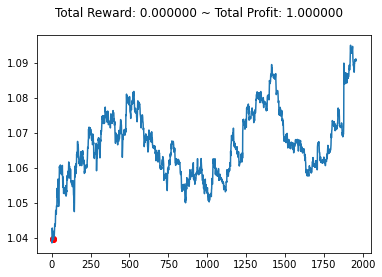

In [2]:
env = gym.make('forex-v0', frame_bound=(50, 2000), window_size=10)
env.reset()
env.render()

In [3]:
nb_actions = env.action_space.n
nb_actions

2

In [4]:
class FileEpisodeLogger(TrainEpisodeLogger):
    def __init__(self, filepath):
        TrainEpisodeLogger.__init__(self)
        self.filepath = filepath
        
    def on_episode_end(self, episode, logs):
        episode_steps = len(self.observations[episode])
        variables = [episode+1, episode_steps, np.sum(self.rewards[episode]), np.mean(self.rewards[episode]), np.mean(self.actions[episode])]
        row = ''
        for var in variables:
            row += '{},'.format(var)
        # Overwrite already open file. We can simply seek to the beginning since the file will
        # grow strictly monotonously.
        with open(self.filepath,'a') as fd:
            fd.write(row[:-1] + '\n')

In [5]:
class EnvProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 2  # (height, width, channel)
        return self.process_obs_1(observation)
    
    def process_obs_1(self, observation):
        prices = []
        diff = []
        for o in observation:
            prices.append(o[0])
            diff.append(o[1])
        prices = preprocessing.normalize([prices], norm='l2', axis=1, copy=True, return_norm=False)[0]
        diff = preprocessing.normalize([diff], norm='l2', axis=1, copy=True, return_norm=False)[0]
        new_obs = np.column_stack((prices, diff))
        return new_obs
    
    def process_obs_2(self, observation):
        prices = []
        diff = []
        for o in observation:
            prices.append(o[0])
            diff.append(o[1] / o[0] * 100)
        prices = preprocessing.normalize([prices], norm='l2', axis=1, copy=True, return_norm=False)[0]
        new_obs = np.column_stack((prices, diff))
        return new_obs
        
    def process_state_batch(self, batch):
#         print(batch)
        return batch

    def process_reward(self, reward):
        return reward

In [6]:
class CustomEpsGreedyQPolicy(EpsGreedyQPolicy):
    def __init__(self, eps=0.1, update_interval=100):
        EpsGreedyQPolicy.__init__(self, eps)
        self.update_interval = update_interval
        self.count = 0
        self.init_eps = self.eps
        
    def select_action(self, q_values):
        assert q_values.ndim == 1
        nb_actions = q_values.shape[0]

        if np.random.uniform() < self.eps:
            action = np.random.randint(0, nb_actions)
        else:
            action = np.argmax(q_values)
        self.count += 1
        if (self.count % self.update_interval) == 0:
            self.eps = self.init_eps / (self.count / self.update_interval)
            print(self.eps)
        return action

# Models

In [7]:
def buildmodelA():
    model = Sequential()
    model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
    model.add(Dropout(0.2))
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(nb_actions))
    model.add(Activation('softmax'))   
    return model

In [8]:
def buildmodelB():
    model = Sequential()
    model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
    model.add(Dropout(0.2))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(nb_actions))
    model.add(Activation('softmax'))   
    return model

# Model/Parameter Selection 

In [9]:
parameter_set="09"
PROCESSOR = EnvProcessor()
#NN
LEARNING_RATE = 0.01
##Policy
POLICY = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05, nb_steps=10000)
#POLICY =MaxBoltzmannQPolicy()
#POLICY = BoltzmannQPolicy()
#POLICY =CustomEpsGreedyQPolicy(update_interval = 2500, eps = 1.0)
#Memory
MEMORY = SequentialMemory(limit=100000, window_length=1)
#Model
MODEL = buildmodelA()
# timesteps to observe before training
OBSERVATION = 20 
#Discount Factor
GAMMA = 0.9 # decay rate of past observations original 0.99
#game parameters
TRAIN_INTERVAL = 32
#Size of Minibatch
BATCH_SIZE = 64 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# DQN

In [10]:
weights_filename = 'dqn_weights_{}.h5f'.format(parameter_set)
checkpoint_weights_filename = 'dqn_weights_{step}_'+'{}.h5f'.format(parameter_set)
log_filename = './Log/dqn_log_{}.csv'.format(parameter_set)
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=250000)]
callbacks += [FileEpisodeLogger(log_filename)]

In [11]:
agent = DQNAgent(model=MODEL, nb_actions=nb_actions, memory=MEMORY, nb_steps_warmup=OBSERVATION
               ,policy=POLICY, batch_size=BATCH_SIZE, processor=PROCESSOR,
               train_interval=TRAIN_INTERVAL,enable_double_dqn=False)
#,enable_double_dqn=True
agent.compile(Adam(lr=LEARNING_RATE), metrics=['mse'])

## Fit Model

In [ ]:
agent.fit(env, nb_steps=1000000, callbacks=callbacks, visualize=False, verbose=2)
agent.save_weights('./Model/dqn_{}_weights.h5f'.format(parameter_set), overwrite=True)

Training for 1000000 steps ...
Training for 1000000 steps ...
   1949/1000000: episode: 1, duration: 1.189s, episode steps: 1949, steps per second: 1639, episode reward: 346.000, mean reward: 0.178 [-63.700, 168.700], mean action: 0.504 [0.000, 1.000], mean observation: 0.157 [-0.973, 0.985], loss: 58.670363, mean_squared_error: 58.797340, mean_q: 0.998477, mean_eps: 0.912160
   3898/1000000: episode: 2, duration: 1.058s, episode steps: 1949, steps per second: 1842, episode reward: 273.600, mean reward: 0.140 [-65.900, 203.400], mean action: 0.534 [0.000, 1.000], mean observation: 0.157 [-0.973, 0.985], loss: 65.918086, mean_squared_error: 66.049737, mean_q: 0.998568, mean_eps: 0.737920
   5847/1000000: episode: 3, duration: 1.007s, episode steps: 1949, steps per second: 1935, episode reward: 282.300, mean reward: 0.145 [-65.900, 204.400], mean action: 0.521 [0.000, 1.000], mean observation: 0.157 [-0.973, 0.985], loss: 64.459180, mean_squared_error: 64.583229, mean_q: 0.999008, mean_e

  52623/1000000: episode: 27, duration: 1.031s, episode steps: 1949, steps per second: 1890, episode reward: 515.700, mean reward: 0.265 [-78.000, 192.900], mean action: 0.620 [0.000, 1.000], mean observation: 0.157 [-0.973, 0.985], loss: 59.138559, mean_squared_error: 59.268498, mean_q: 0.998889, mean_eps: 0.100000
  54572/1000000: episode: 28, duration: 1.003s, episode steps: 1949, steps per second: 1944, episode reward: 499.900, mean reward: 0.256 [-65.900, 195.200], mean action: 0.509 [0.000, 1.000], mean observation: 0.157 [-0.973, 0.985], loss: 67.578425, mean_squared_error: 67.702754, mean_q: 0.998861, mean_eps: 0.100000
  56521/1000000: episode: 29, duration: 1.002s, episode steps: 1949, steps per second: 1946, episode reward: 853.900, mean reward: 0.438 [-79.800, 168.700], mean action: 0.462 [0.000, 1.000], mean observation: 0.157 [-0.973, 0.985], loss: 54.165314, mean_squared_error: 54.297170, mean_q: 0.998936, mean_eps: 0.100000
  58470/1000000: episode: 30, duration: 1.000s

## Test

In [ ]:
agent.load_weights('./Model/dqn_{}_weights.h5f'.format(parameter_set))

In [ ]:
env_test = gym.make('forex-v0', frame_bound=(50,2000), window_size=10)
env_test.trade_fee = 0
env_test.reset()

In [ ]:
agent.test(env_test,visualize=False)

In [ ]:
print(env_test.max_possible_profit())
plt.cla()
env_test.render_all()
plt.show()

## Plot Train Graph

In [ ]:
csv_data = pd.read_csv('./Log/dqn_log_{}.csv'.format(parameter_set), delimiter=',', header=None)
plt.plot(csv_data[0],csv_data[2])